In [2]:
import pandas as pd
_tp = pd.read_json('tp.jsonl', lines=True)
_cp = pd.read_json('cp_shardq2.jsonl', lines=True)


In [3]:
tp = _tp.copy()


# Only tp_size == 4
tp = tp[tp['tp_size'] == 4]
# Only keep num_qo_heads == 32, num_kv_heads == 8
tp = tp[(tp['num_qo_heads'] == 32) & (tp['num_kv_heads'] == 8)]
tp = tp[['rank', 'batch_size', 'qo_len', 'computed_time']]
tp.head()

,rank,batch_size,qo_len,computed_time
11,0,1,1024,0.443328
12,0,1,2048,0.440736
13,0,1,4096,0.628640
14,0,1,8192,1.585376
15,0,1,16384,5.683136


In [4]:
cp = _cp.copy()
cp_degree = 4
cp = cp[cp['cp_degree'] == cp_degree]
cp['computed_time'] = cp['median_compute_time']
cp = cp[['rank', 'batch_size', 'qo_len', 'computed_time']]
cp['qo_len'] = cp['qo_len'] * cp_degree
cp.head()

,rank,batch_size,qo_len,computed_time
0,0,1,8192,2.141344
1,0,1,16384,7.932640
2,0,1,32768,29.975808
3,0,1,65536,107.664467
4,0,1,131072,428.528091


In [5]:
# Remove duplicate entries for tp
tp = tp.drop_duplicates(subset=['rank', 'batch_size', 'qo_len'], keep='first')

# Remove duplicate entries for cp
cp = cp.drop_duplicates(subset=['rank', 'batch_size', 'qo_len'], keep='first')


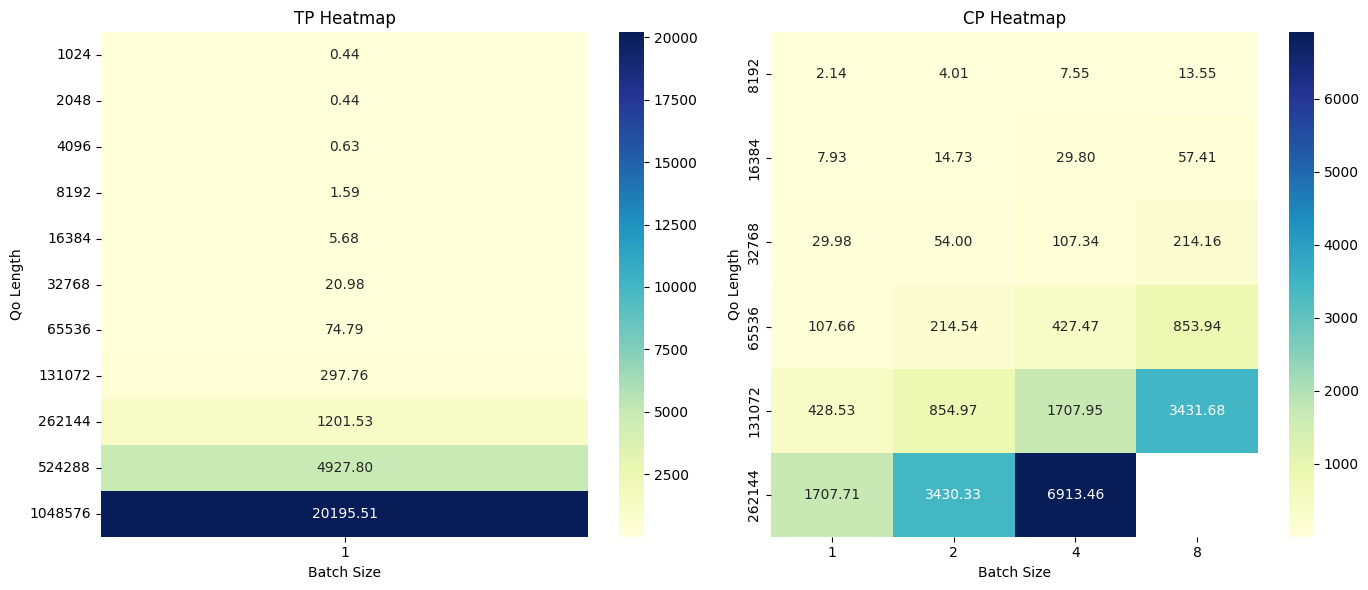

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Create heatmap for tp
tp_pivot = tp.pivot(index="qo_len", columns="batch_size", values="computed_time")
sns.heatmap(tp_pivot, ax=axes[0], cmap="YlGnBu", annot=True, fmt=".2f")
axes[0].set_title('TP Heatmap')
axes[0].set_xlabel('Batch Size')
axes[0].set_ylabel('Qo Length')

# Create heatmap for cp
cp_pivot = cp.pivot(index="qo_len", columns="batch_size", values="computed_time")
sns.heatmap(cp_pivot, ax=axes[1], cmap="YlGnBu", annot=True, fmt=".2f")
axes[1].set_title('CP Heatmap')
axes[1].set_xlabel('Batch Size')
axes[1].set_ylabel('Qo Length')

plt.tight_layout()
plt.show()


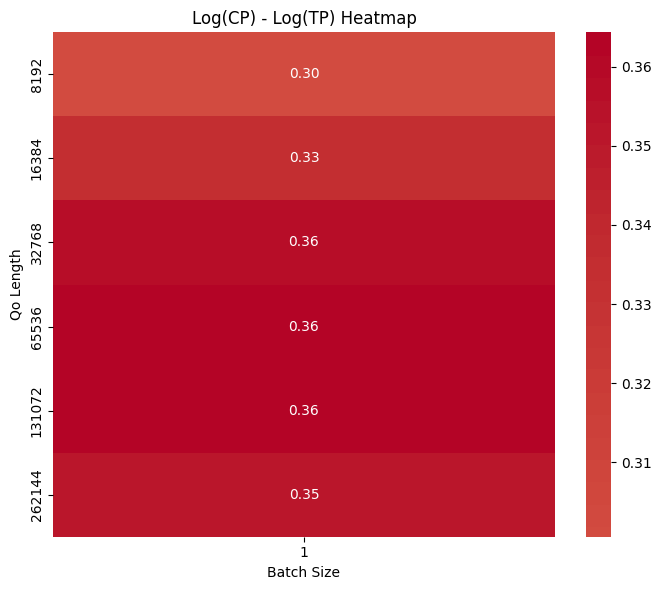

In [7]:
import numpy as np

# Calculate log(cp) - log(tp)
# First, ensure both dataframes have the same index and columns for valid subtraction
common_index = cp_pivot.index.intersection(tp_pivot.index)
common_columns = cp_pivot.columns.intersection(tp_pivot.columns)

# Filter both dataframes to have only common indices and columns
cp_filtered = cp_pivot.loc[common_index, common_columns]
tp_filtered = tp_pivot.loc[common_index, common_columns]

# Calculate the difference in log scale
log_diff = np.log(cp_filtered) - np.log(tp_filtered)

# Create heatmap for log(cp) - log(tp)
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(log_diff, ax=ax, cmap="coolwarm", annot=True, fmt=".2f", center=0)
ax.set_title('Log(CP) - Log(TP) Heatmap')
ax.set_xlabel('Batch Size')
ax.set_ylabel('Qo Length')

plt.tight_layout()
plt.show()
